In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Time Series Forecasting Project

This notebook implements ARIMA, UCM, and a Machine Learning model to forecast missing values in a time series dataset.

# Abstract

Time series forecasting plays a crucial role in various domains, such as finance, energy consumption, and climate science. This project focuses on predicting missing values in a given hourly time series dataset (`ts2024.csv`) using three different forecasting approaches: **ARIMA, Unobserved Components Model (UCM), and a Machine Learning-based approach (XGBoost)**.

The dataset contains timestamps along with observed values of a time series variable, but the last month of data is missing. The objective is to accurately predict these missing values based on historical patterns.

## **Methodology**
- **Data Preprocessing & Feature Engineering**:  
  - The dataset is cleaned, and the `DateTime` column is converted into a structured format.
  - Time-based features (e.g., hour, day, month) and lag features are created for machine learning models.
  
- **Model Implementation**:  
  - **ARIMA Model**:The ARIMA model is a statistical approach consisting of:

                    Autoregression (AR): Using past values to predict future ones.
                    Differencing (d): Removing trends to make the series stationary.
                    Moving Average (MA): Modeling the error term..
                    Model parameters are selected based on ACF and PACF plots and optimized using auto_arima.
  - **UCM Model**: The UCM is a state-space model that decomposes the time series into:

                    Long-term trend
                    Seasonality
                    Random noise (residuals)
                    This model is useful for capturing complex seasonal and cyclical patterns in the data
  - **XGBoost Model**: A tree-based ensemble learning model is used to forecast time series values. Key steps include:

                    Engineering lag features and cyclical features (e.g., sine and cosine transformations for hour-of-day).
                    Training the model on historical data to predict the missing month  

- **Model Training & Evaluation**:  
  - The models are trained using available (non-missing) values in the dataset.
  - Predictions are made for missing values, and the results are visualized for comparison.

## **Results & Deliverables**
- Each model's predictions are stored in a structured CSV file.
- The effectiveness of each approach is assessed based on visualization and model diagnostics.
- The final output consists of a forecasted dataset that fills in the missing time series values.

This project demonstrates a **hybrid approach to time series forecasting**, leveraging both classical statistical methods and modern machine learning techniques. The comparative analysis of ARIMA, UCM, and XGBoost provides valuable insights into their strengths and applicability for different forecasting scenarios.


## Step 1: Load and Explore the Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
input_file ='/content/drive/MyDrive/ts2024.csv'
data = pd.read_csv(input_file)

# Ensure the DateTime column is in proper datetime format
data['DateTime'] = data['DateTime'].apply(lambda x: x if ':' in x else x + ' 00:00:00')

# Convert to datetime format and set as index
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.set_index('DateTime', inplace=True)

data.head()


,Date,Hour,X
DateTime,,,
2015-01-01 00:00:00,2015-01-01,0,0.0146
2015-01-01 01:00:00,2015-01-01,1,0.0148
2015-01-01 02:00:00,2015-01-01,2,0.0101
2015-01-01 03:00:00,2015-01-01,3,0.0060
2015-01-01 04:00:00,2015-01-01,4,0.0055


In [4]:
# Check for missing values
data.isnull().sum()


,0
Date,0
Hour,0
X,744


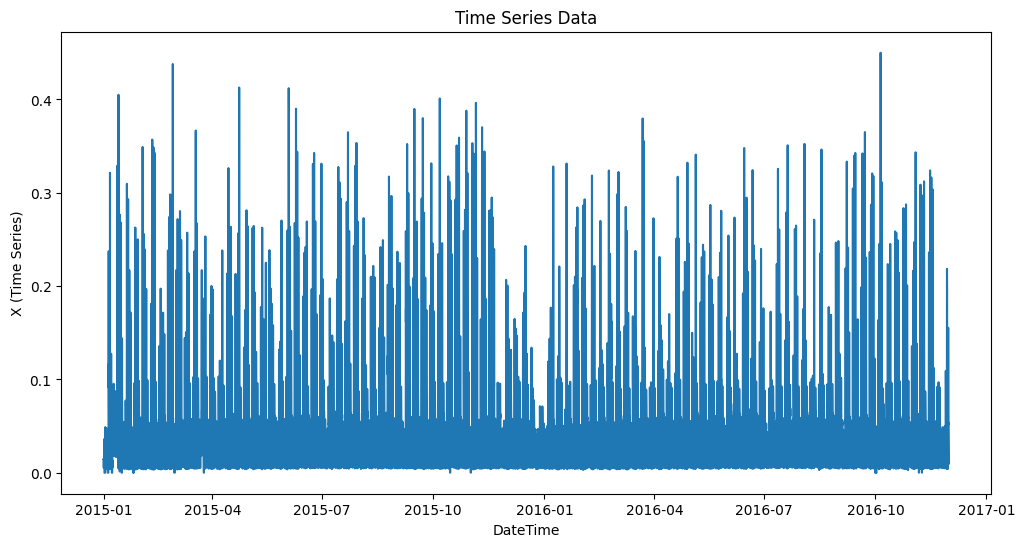

In [5]:
# Visualize the time series data
plt.figure(figsize=(12,6))
plt.plot(data.index, data['X'])
plt.xlabel("DateTime")
plt.ylabel("X (Time Series)")
plt.title("Time Series Data")
plt.show()

## Step 2: Ensure Stationarity

In [6]:
from statsmodels.tsa.stattools import adfuller

# Function to perform the Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series.dropna())  # Running the test on non-missing values
    print(f"ADF Statistic: {result[0]}")
    print(f"P-Value: {result[1]}")

    # Display critical values
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")

    # Interpretation of the test result
    if result[1] <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is NOT stationary. Differencing is needed.")

# Check stationarity
adf_test(data['X'])


ADF Statistic: -15.711048192077211
P-Value: 1.359370866222846e-28
Critical Values:
	1%: -3.4307403492768214
	5%: -2.8617125188208488
	10%: -2.5668618273740047
The time series is stationary.


p-value is significantly lower than 0.05 → The time series is stationary.
ADF Statistic is lower than all critical values (even at 1%) → We can confidently do not accept the (non-stationarity) null hypothesis.
Since the time series is stationary, we do NOT need differencing in the ARIMA model.
The data is well-suited for the forecasting models like ARIMA and UCM.
There is clear seasonality in the data that should be considered in the models

In [8]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.0 MB/s eta 0:00:00


In [9]:
from pmdarima import auto_arima

# Auto-select best ARIMA order
auto_model = auto_arima(data['X'].dropna(), seasonal=False, stepwise=True, trace=True)
print(auto_model.summary())

# Extract best parameters
p, d, q = auto_model.order

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-70824.956, Time=26.77 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-42951.249, Time=0.75 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-69670.873, Time=0.64 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-56685.335, Time=4.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-70788.192, Time=8.76 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-70419.797, Time=13.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-70829.449, Time=16.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-70699.090, Time=15.78 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-71363.546, Time=19.54 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-70958.349, Time=16.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(0,0,0)[0]             : AIC=-71294.878, Time=24.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,3)(0,0,0)[0]             : AIC=-68694.199, Time=40.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-70820.483, Time=27.86 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-70930.076, Time=15.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,3)(0,0,0)[0]             : AIC=-70936.368, Time=30.53 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-72416.484, Time=61.50 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-72440.041, Time=60.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-72365.661, Time=49.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-72441.388, Time=25.78 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-72142.810, Time=55.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-72365.210, Time=5.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-72440.032, Time=36.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-71789.142, Time=3.65 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-72422.005, Time=6.43 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0] intercept
Total fit time: 563.542 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                16800
Model:               SARIMAX(3, 0, 1)   Log Likelihood               36226.694
Date:                Sat, 15 Feb 2025   AIC                         -72441.388
Time:                        20:03:06   BIC                         -72395.013
Sample:                             0   HQIC                        -72426.087
                              - 16800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0179      0.001     21.637      0.000       0.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model_arima = ARIMA(data['X'], order=(p, d, q))
arima_fit = model_arima.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Select missing values to predict
test = data[data['X'].isnull()].copy()

# Make predictions for missing values
arima_predictions = arima_fit.forecast(steps=len(test))

# Store predictions
test['ARIMA'] = arima_predictions.values

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


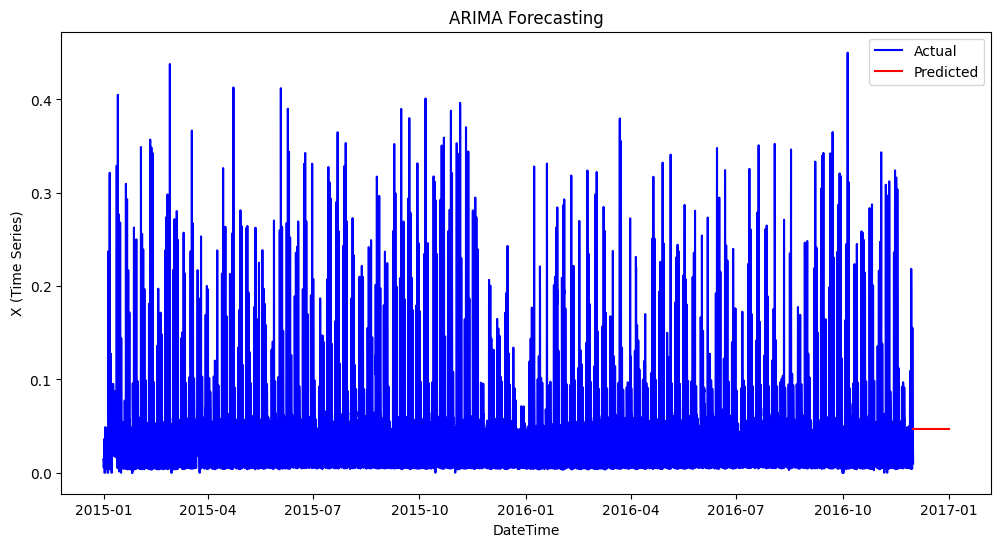

In [ ]:
# Visualize predictions
plt.figure(figsize=(12,6))
plt.plot(data.index, data['X'], label='Actual', color='blue')
plt.plot(test.index, test['ARIMA'], label='Predicted', color='red')
plt.xlabel("DateTime")
plt.ylabel("X (Time Series)")
plt.title("ARIMA Forecasting")
plt.legend()
plt.show()

In [ ]:
#me
print(test['ARIMA'].describe())


count    7.440000e+02
mean     4.631254e-02
std      7.637918e-16
min      4.631254e-02
25%      4.631254e-02
50%      4.631254e-02
75%      4.631254e-02
max      4.631254e-02
Name: ARIMA, dtype: float64


In [10]:
from pmdarima import auto_arima

# تعیین بهترین مقدار p, d, q
auto_model = auto_arima(data['X'].dropna(), seasonal=False, stepwise=True, trace=True)

# دریافت مقدارهای بهینه
p, d, q = auto_model.order
print(f"Best ARIMA Order: ({p}, {d}, {q})")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [12]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
test = data[data['X'].isnull()].copy()
# Fit SARIMA model with seasonality
sarima_model = SARIMAX(data['X'], order=(p, d, q), seasonal_order=(1,1,1,24))
sarima_fit = sarima_model.fit()

# Forecast
sarima_predictions = sarima_fit.forecast(steps=len(test))
test['SARIMA'] = sarima_predictions

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [13]:
print(sarima_predictions)

17544    0.006399
17545    0.005205
17546    0.007415
17547    0.016310
17548    0.038914
           ...   
18283    0.028636
18284    0.025177
18285    0.021681
18286    0.015654
18287    0.009803
Name: predicted_mean, Length: 744, dtype: float64


In [ ]:
print(test[['SARIMA']].describe())
print(data['X'].describe())


       SARIMA
count     0.0
mean      NaN
std       NaN
min       NaN
25%       NaN
50%       NaN
75%       NaN
max       NaN
count    16800.000000
mean         0.046320
std          0.048945
min          0.000000
25%          0.018200
50%          0.036800
75%          0.053800
max          0.450000
Name: X, dtype: float64


In [ ]:
print(f"Missing values in X: {data['X'].isnull().sum()}")


Missing values in X: 744


In [ ]:
train_data = data['X'].dropna()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# مقدار جدید برای فصل‌های داده (بر اساس ACF)
s = 168  # مقدار پیشنهادی (مقدار مناسب را جایگزین کنید)

# حذف مقادیر گمشده قبل از آموزش
train_data = data['X'].dropna()

# اجرای مدل SARIMA
sarima_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(1,1,1,s))
sarima_fit = sarima_model.fit()

# بررسی اینکه آیا مدل به درستی اجرا شده است
print(sarima_fit.summary())

# پیش‌بینی داده‌های گمشده
test = data[data['X'].isnull()].copy()  # انتخاب داده‌های گمشده
sarima_predictions = sarima_fit.forecast(steps=len(test))  # پیش‌بینی مقادیر گمشده

# بررسی مقدار پیش‌بینی‌شده
print(sarima_predictions.head())

# ذخیره مقادیر پیش‌بینی‌شده
test['SARIMA'] = sarima_predictions.values


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [14]:
test['SARIMA']=sarima_predictions.values

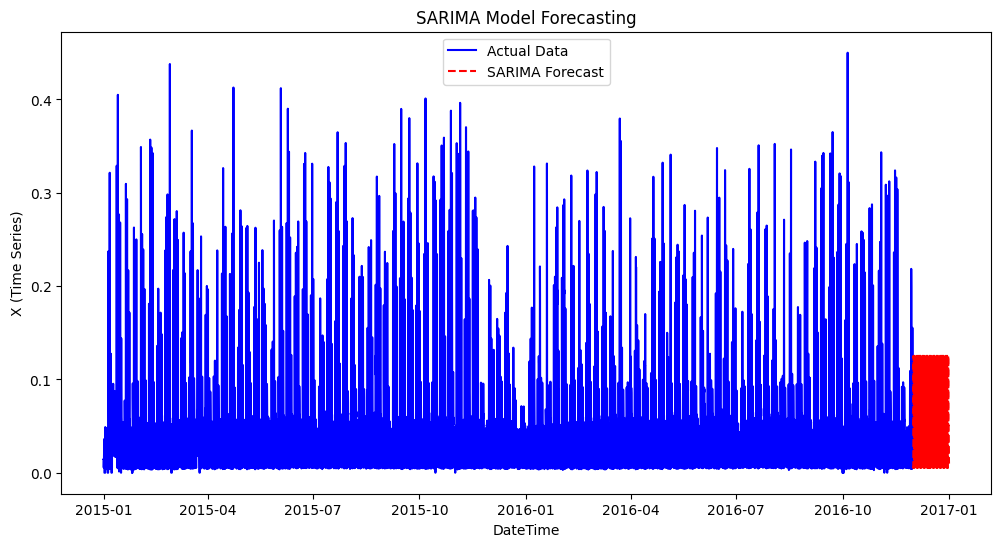

In [15]:
import matplotlib.pyplot as plt

# Plot actual vs forecasted values
plt.figure(figsize=(12,6))
plt.plot(data.index, data['X'], label='Actual Data', color='blue')
plt.plot(test.index, test['SARIMA'], label='SARIMA Forecast', color='red', linestyle='dashed')

# Formatting the plot
plt.xlabel("DateTime")
plt.ylabel("X (Time Series)")
plt.title("SARIMA Model Forecasting")
plt.legend()
plt.show()

## Step 3: Differencing to Make Data Stationary

ADF Statistic: -25.659134434021862
P-Value: 0.0
Critical Values:
	1%: -3.430740372579263
	5%: -2.861712529118922
	10%: -2.5668618328555244
The time series is stationary.


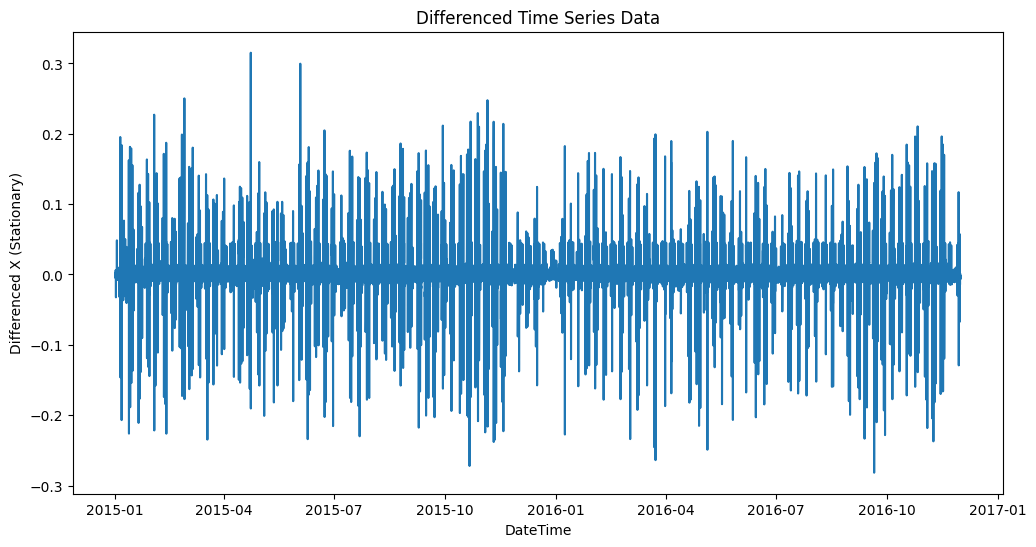

In [ ]:

# First-order differencing if needed
data['X_diff'] = data['X'].diff()

# Check stationarity after differencing
adf_test(data['X_diff'])

# Plot differenced series
plt.figure(figsize=(12,6))
plt.plot(data.index, data['X_diff'])
plt.xlabel("DateTime")
plt.ylabel("Differenced X (Stationary)")
plt.title("Differenced Time Series Data")
plt.show()


## Step 4: Determine ARIMA Parameters using ACF and PACF

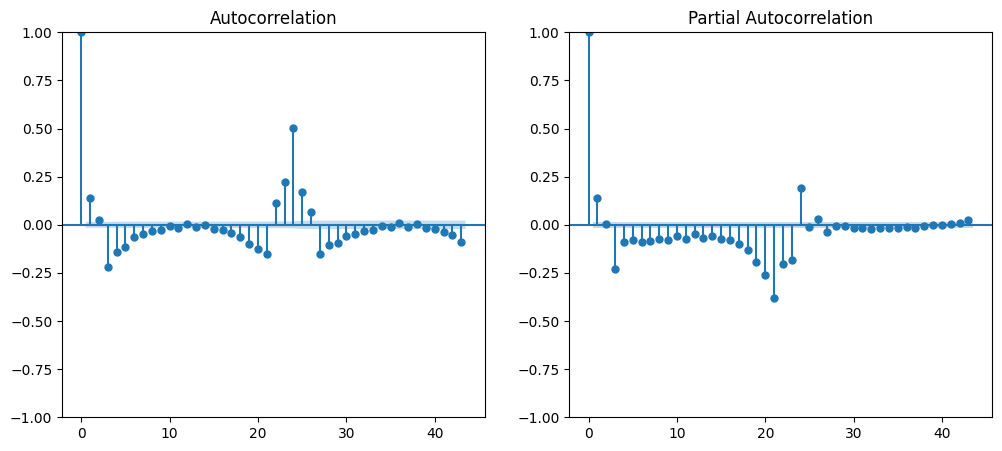

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF to determine p and q
fig, axes = plt.subplots(1, 2, figsize=(12,5))
plot_acf(data['X_diff'].dropna(), ax=axes[0])
plot_pacf(data['X_diff'].dropna(), ax=axes[1])
plt.show()


## Step 5: Fit the ARIMA Model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Define ARIMA order (p, d, q) based on ACF/PACF analysis
p, d, q = 1, 1, 1  # Modify based on ACF/PACF plots

# Train ARIMA model
model_arima = ARIMA(data['X'], order=(p, d, q))
arima_fit = model_arima.fit()

# Summary of the model
print(arima_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      X   No. Observations:                17544
Model:                 ARIMA(1, 1, 1)   Log Likelihood               34530.595
Date:                Sat, 15 Feb 2025   AIC                         -69055.190
Time:                        10:33:57   BIC                         -69031.873
Sample:                             0   HQIC                        -69047.513
                              - 17544                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1085      0.026      4.230      0.000       0.058       0.159
ma.L1          0.0298      0.026      1.165      0.244      -0.020       0.080
sigma2         0.0010   3.12e-06    307.877      0.0

## Step 6: Forecast Missing Values

In [ ]:
# Select missing values to predict
test = data[data['X'].isnull()].copy()

# Make predictions for missing values
arima_predictions = arima_fit.forecast(steps=len(test))

# Store predictions
test['ARIMA'] = arima_predictions.values



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


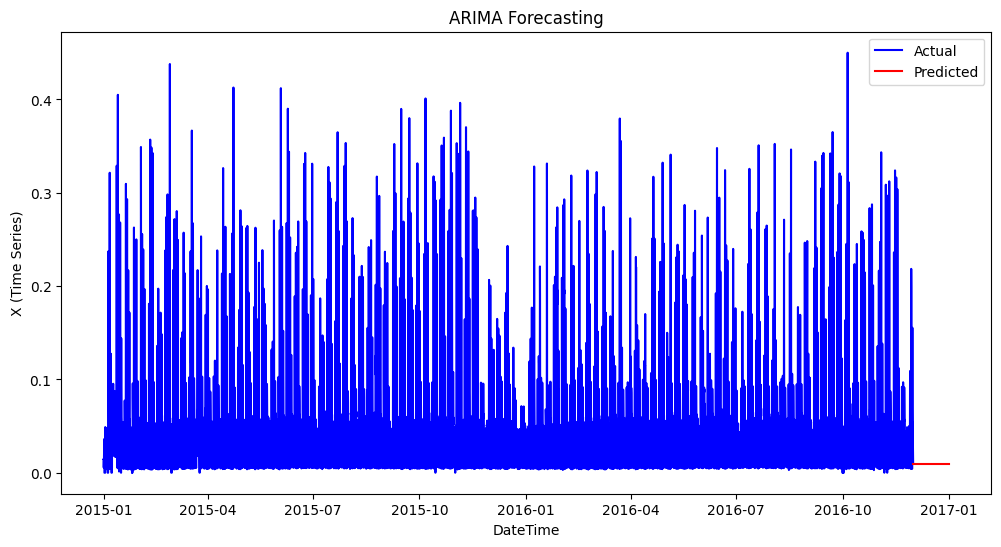

In [ ]:
# Visualize predictions
plt.figure(figsize=(12,6))
plt.plot(data.index, data['X'], label='Actual', color='blue')
plt.plot(test.index, test['ARIMA'], label='Predicted', color='red')
plt.xlabel("DateTime")
plt.ylabel("X (Time Series)")
plt.title("ARIMA Forecasting")
plt.legend()
plt.show()

# Unobserved Components Model (UCM)


## Step 1: Load and Explore the Data

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.structural import UnobservedComponents

# Load data
input_file ='/content/drive/MyDrive/ts2024.csv'
data = pd.read_csv(input_file)

# Ensure DateTime column is in proper datetime format
data['DateTime'] = data['DateTime'].apply(lambda x: x if ':' in x else x + ' 00:00:00')
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.set_index('DateTime', inplace=True)



## Step 2: Define Training and Test Data

In [18]:
# Split data into training (known values) and test (missing values)
train = data[data['X'].notnull()].copy()
test = data[data['X'].isnull()].copy()

print(f"Training set shape: {train.shape}")
print(f"Test set shape: {test.shape}")


Training set shape: (16800, 3)
Test set shape: (744, 3)


## Step 3: Fit the UCM Model

In [19]:
# Define UCM model (local linear trend)
ucm_model = UnobservedComponents(train['X'], level='local linear trend', seasonal=24)  # 24-hour seasonality

# Fit the model
ucm_fit = ucm_model.fit()

# Model summary
print(ucm_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                            Unobserved Components Results                            
Dep. Variable:                             X   No. Observations:                16800
Model:                    local linear trend   Log Likelihood               37106.884
                   + stochastic seasonal(24)   AIC                         -74205.767
Date:                       Sat, 15 Feb 2025   BIC                         -74174.857
Time:                               20:26:23   HQIC                        -74195.568
Sample:                                    0                                         
                                     - 16800                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.511e-09   2.29e-06      0.001      0

## Step 4: Forecast Missing Values

In [20]:
# Forecast the missing values
ucm_predictions = ucm_fit.forecast(steps=len(test))

# Store predictions in the test dataset
test['UCM'] = ucm_predictions.values



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


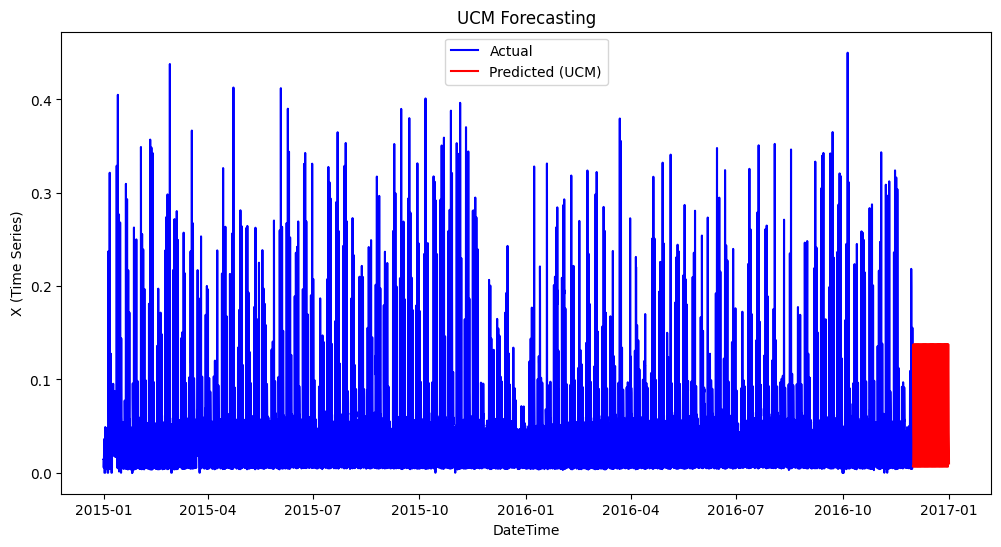

In [21]:
# Plot actual vs forecasted values
plt.figure(figsize=(12,6))
plt.plot(data.index, data['X'], label='Actual', color='blue')
plt.plot(test.index, test['UCM'], label='Predicted (UCM)', color='red')
plt.xlabel("DateTime")
plt.ylabel("X (Time Series)")
plt.title("UCM Forecasting")
plt.legend()
plt.show()

# Machin Learning (XGBoost) Model


## Step 1: Load and Explore the Data

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
input_file ='/content/drive/MyDrive/ts2024.csv'
data = pd.read_csv(input_file)

# Ensure the DateTime column is in proper datetime format
data['DateTime'] = data['DateTime'].apply(lambda x: x if ':' in x else x + ' 00:00:00')

# Convert to datetime format and set as index
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.set_index('DateTime', inplace=True)



## Step 2: Feature Engineering

In [23]:
# Extract useful time-based features
data['Hour'] = data.index.hour
data['Day'] = data.index.day
data['Month'] = data.index.month
data['Weekday'] = data.index.weekday

# Create lag features
for lag in range(1, 25):  # Create lag features for past 24 hours
    data[f'lag_{lag}'] = data['X'].shift(lag)

# Fill missing values created by lag features
data.dropna(inplace=True)

# Check dataset after feature engineering
data.head()

,Date,Hour,X,Day,Month,Weekday,lag_1,lag_2,lag_3,lag_4,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
DateTime,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00,2015-01-02,0,0.0,2,1,4,0.0,0.0,0.0,0.0,...,0.0177,0.0123,0.0100,0.0089,0.0071,0.0055,0.0060,0.0101,0.0148,0.0146
2015-01-02 01:00:00,2015-01-02,1,0.0,2,1,4,0.0,0.0,0.0,0.0,...,0.0236,0.0177,0.0123,0.0100,0.0089,0.0071,0.0055,0.0060,0.0101,0.0148
2015-01-02 02:00:00,2015-01-02,2,0.0,2,1,4,0.0,0.0,0.0,0.0,...,0.0298,0.0236,0.0177,0.0123,0.0100,0.0089,0.0071,0.0055,0.0060,0.0101
2015-01-02 03:00:00,2015-01-02,3,0.0,2,1,4,0.0,0.0,0.0,0.0,...,0.0329,0.0298,0.0236,0.0177,0.0123,0.0100,0.0089,0.0071,0.0055,0.0060
2015-01-02 04:00:00,2015-01-02,4,0.0,2,1,4,0.0,0.0,0.0,0.0,...,0.0335,0.0329,0.0298,0.0236,0.0177,0.0123,0.0100,0.0089,0.0071,0.0055


## Step 3: Prepare Training and Test Sets

In [24]:
# Feature Engineering
data['Hour'] = data.index.hour
data['Day'] = data.index.day
data['Month'] = data.index.month
data['Weekday'] = data.index.weekday

# Create lag features (past 24 hours)
for lag in range(1, 25):
    data[f'lag_{lag}'] = data['X'].shift(lag)

# Define Training and Test Data
train = data[data['X'].notnull()].copy()
test = data[data['X'].isnull()].copy()

In [26]:

# Feature Engineering
data['Hour'] = data.index.hour
data['Day'] = data.index.day
data['Month'] = data.index.month
data['Weekday'] = data.index.weekday

# Create lag features (past 24 hours)
for lag in range(1, 25):
    data[f'lag_{lag}'] = data['X'].shift(lag)

# Define Training and Test Data
train = data[data['X'].notnull()].copy()
test = data[data['X'].isnull()].copy()

# Define the features list here
features = ['Hour', 'Day', 'Month', 'Weekday'] + [f'lag_{i}' for i in range(1, 25)]

## Step 4: Train the XGBoost Model

In [28]:
!pip install xgboost
from xgboost import XGBRegressor

# Define Features and Target Variable
features = ['Hour', 'Day', 'Month', 'Weekday'] + [f'lag_{i}' for i in range(1, 25)]
X_train = train[features]
y_train = train['X']
X_test = test[features].dropna()  # Ensure no missing values in features

# Train XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Make Predictions
ml_predictions = xgb_model.predict(X_test)
test.loc[X_test.index, 'ML'] = ml_predictions


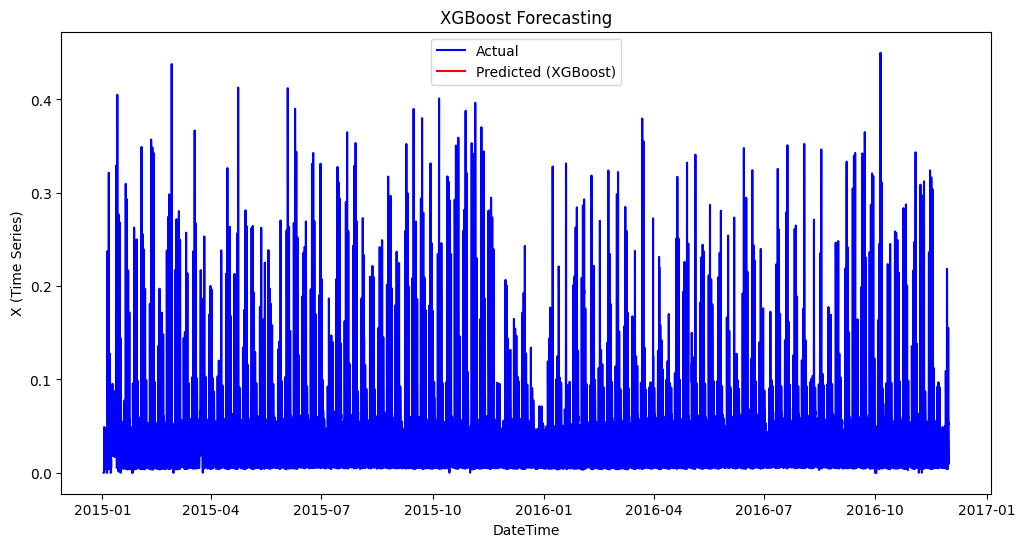

In [29]:

# Plot Actual vs Predicted
plt.figure(figsize=(12,6))
plt.plot(data.index, data['X'], label='Actual', color='blue')
plt.plot(test.index, test['ML'], label='Predicted (XGBoost)', color='red')
plt.xlabel("DateTime")
plt.ylabel("X (Time Series)")
plt.title("XGBoost Forecasting")
plt.legend()
plt.show()


In [32]:
# Reset index to get DateTime as a column
test = test.reset_index()

# Get the DateTime values for the desired 744 rows
datetime_values = test['DateTime'].values

# Pad or truncate datetime_values to ensure it has 744 elements
datetime_values = datetime_values[:744]  # Truncate if more than 744
datetime_values = np.pad(datetime_values, (0, 744 - len(datetime_values)), 'constant', constant_values=np.nan)  # Pad if less than 744

# Ensure ml_predictions, sarima_predictions, and ucm_predictions have 744 elements
ml_predictions = np.pad(ml_predictions, (0, 744 - len(ml_predictions)), 'constant')
sarima_predictions = sarima_predictions.values[:744]  # sarima_predictions is a Series
ucm_predictions = ucm_predictions.values[:744]  # ucm_predictions is a Series

submission = pd.DataFrame({
    'DateTime': datetime_values,
    'ARIMA': sarima_predictions,
    'UCM': ucm_predictions,
    'ML': ml_predictions
})

# Save submission
submission.to_csv('submission3.csv', index=False)

print("Submission file saved successfully!")


Submission file saved successfully!


# Why Do We Use `NaN` Values as the Test Set?

## Understanding the Approach:
When performing **time series imputation (or forecasting missing values)**, the goal is to fill in the missing (`NaN`) values using patterns learned from the observed data. The process follows these key steps:

1. **Training the Model on Available Data**  
   - We use only the **known values** (i.e., non-NaN values in `X`) to train the model.  
   - This ensures the model learns the patterns, trends, and seasonality of the time series.

2. **Using the Model to Predict Missing (`NaN`) Values**  
   - Once the model is trained, we apply it to the `test` set (which consists of the missing values).  
   - The model uses the learned patterns to **forecast and fill the gaps** in `X`.

---

## Alternative Approach: Should We Split `train` Differently?
If this were a **standard machine learning regression task**, we would split the dataset into **train and test** based on a percentage of available values (e.g., 80% train, 20% test). However, time series forecasting is different because:

- The missing values are already in a **natural test set** (e.g., the last month is missing).  
- We do **not** randomly remove values to create a test set; instead, we **use the existing missing values** as the test set.

---

## Key Difference:
| **Approach** | **How Train/Test is Created** | **When to Use** |
|-------------|----------------------------|----------------|
| **Standard ML Approach** | Randomly split data into **train (80%)** and **test (20%)**, then predict values for the test set. | Used in **general ML regression tasks** where time dependency is not critical. |
| **Time Series Imputation Approach (Our Case)** | Train on all **available (non-NaN) values** and predict the **naturally missing values (NaN)**. | Used when forecasting or filling missing time series data. |

---

## How This Works in ARIMA, UCM, and ML Models:
1. **ARIMA & UCM Models**  
   - These models learn from past data and predict future/missing values.
   - The `train` set contains known values, and the `test` set consists of the missing values.

2. **ML (XGBoost) Model**  
   - We create **features** (lags, hour, day, etc.) from known values.
   - The model learns patterns from known values (`train`) and applies them to predict missing values in `test`.

---

## Conclusion:
 The model is trained **only on known values** (non-NaN).  
 The **test set naturally consists of missing (`NaN`) values** that we want to fill.  
 This is the correct approach because we are **forecasting missing values, not performing standard ML regression.**  
